In [205]:
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import os
import pandas as pd

In [206]:
def read_file(file_name):
    # Get current working directory and go up one level (from src to project root)
    current_dir = os.getcwd()
    base_dir = os.path.dirname(current_dir)
    target_path = os.path.join(base_dir, file_name)    

    file_contents = ""
    data = []

    try:
        with open(target_path) as f:
            file_contents = f.readlines()

        for line in file_contents:
            data.append(tuple(map(int, (line.split()))))

        return data
    except FileNotFoundError:
        print(f"File not found: {target_path}")
        return None


def get_item_att(items, ind):
    value = 0
    weight = 0

    for i, att in enumerate(ind):
        if(att == 1):
           (value_ind, weight_ind) = items[i]
           value += value_ind
           weight += weight_ind 

    return (value, weight)

In [207]:
main_dic = os.getcwd()
knapsack_10 = "data/knapsack-data_2/10_269"

data = read_file(knapsack_10)


In [208]:
def calc_fitness(max_weight, items, ind):
    value = 0
    weight = 0

    for i, att in enumerate(ind):
        if att == 1:
            value_ind, weight_ind = items[i]
            value += value_ind
            weight += weight_ind

    if weight > max_weight:
        # Penalty proportional to how overweight it is
        penalty = ((weight - max_weight) / max_weight) * value
        fitness = value - penalty
        # Ensure fitness is negative if overweight
        if fitness > 0:
            fitness = -fitness
        # print(f"Weight: {weight} | Fitness: {fitness}")
        return fitness
    else:
        return value


In [220]:
def EDA(items, item_size, max_weight, pop_size=200, gens=100, 
        Nbest=8, Nworst=6, pmin=0.05, pmax=0.95, eta=0.01, seed=1000):
    
    np.random.seed(seed)

    prob = np.full(item_size, 0.5)

    best_solution, best_value = None, 0
    gen_best_values = []     # log best fitness per generation
    gen_best_solutions = []  # log best individuals per generation

    for g in range(gens):
        # --- Generate population ---
        population = (np.random.rand(pop_size, item_size) < prob).astype(int)

        # --- Evaluate fitness ---
        fitness = np.array([calc_fitness(max_weight, items, ind) for ind in population])

        # --- Sort individuals by fitness ---
        sorted_idx = np.argsort(fitness)
        population = population[sorted_idx]
        fitness = fitness[sorted_idx]

        # --- Best of this generation ---
        gen_best_values.append(fitness[-1])
        gen_best_solutions.append(population[-1])

        # --- Update global best ---
        if fitness[-1] > best_value:
            best_value = fitness[-1]
            best_solution = population[-1]

        # --- Update probability vector ---
        for i in range(Nbest):  
            xi = population[-(i+1)]
            prob = prob + eta * (xi - prob)

        for i in range(Nworst): 
            xi = population[i]
            prob = prob - eta * (xi - prob)

        prob = np.clip(prob, pmin, pmax)

        print(f"Gen {g+1}: Gen best = {fitness[-1]}, Overall best = {best_value}")

    return best_solution, best_value, gen_best_solutions, gen_best_values


In [232]:

def run_with_seed(items, seeds = [1,100,1000]):

    (num_items, bag_cap)= items.pop(0)

    seed_res = []

    for seed in seeds:
        (best_solution, best_value, gen_best_solutions, gen_best_values) = EDA(items, num_items, bag_cap, seed=seed)

        seed_res.append({
            "seed":seed,
            "best_values": gen_best_values
        })

        
    return seed_res
        


def plot_fitness(fitnesses, title="Fitness Over Epochs"):
    plt.figure(figsize=(10, 6))
    plt.plot(fitnesses, label="Fitness")
    plt.xlabel("Epoch")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def best_individual_stats(seed_res, plot=True):
    """
    Computes mean and std of the best individuals across all seeds.
    
    Parameters
    ----------
    seed_res : list of dicts
        Output from run_with_seed, each dict has keys 'seed' and 'best_values'
    plot : bool
        If True, plots the best values per seed
    
    Returns
    -------
    stats : pd.DataFrame
        DataFrame with columns ['seed', 'final_best']
    mean_best : float
        Mean of final best individuals across seeds
    std_best : float
        Std of final best individuals across seeds
    """
    # Extract the final best value from each seed
    final_bests = [res['best_values'][-1] for res in seed_res]
    
    # Create DataFrame
    stats = pd.DataFrame({
        'seed': [res['seed'] for res in seed_res],
        'final_best': final_bests
    })
    
    mean_best = np.mean(final_bests)
    std_best = np.std(final_bests)
    
    if plot:
        plt.figure(figsize=(8,5))
        plt.bar(stats['seed'], stats['final_best'], alpha=0.7)
        plt.axhline(mean_best, color='red', linestyle='--', label=f'Mean={mean_best:.2f}')
        plt.fill_between(stats['seed'], mean_best-std_best, mean_best+std_best, color='red', alpha=0.2, label=f'±1 std')
        plt.xlabel('Seed')
        plt.ylabel('Final Best Fitness')
        plt.title('Final Best Fitness Across Seeds')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return stats, mean_best, std_best


Gen 1: Gen best = -259529.2824120603, Overall best = 0
Gen 2: Gen best = -190790.72864321608, Overall best = 0
Gen 3: Gen best = -139217.8894472362, Overall best = 0
Gen 4: Gen best = -164001.23819095478, Overall best = 0
Gen 5: Gen best = -203575.2824120603, Overall best = 0
Gen 6: Gen best = -71099.76180904523, Overall best = 0
Gen 7: Gen best = -96012.44221105528, Overall best = 0
Gen 8: Gen best = -109220.83417085426, Overall best = 0
Gen 9: Gen best = -79145.77286432161, Overall best = 0
Gen 10: Gen best = -77381.67638190954, Overall best = 0
Gen 11: Gen best = -51197.427135678394, Overall best = 0
Gen 12: Gen best = -34886.51658291457, Overall best = 0
Gen 13: Gen best = -49051.79497487437, Overall best = 0
Gen 14: Gen best = -41996.49246231156, Overall best = 0
Gen 15: Gen best = -31581.346733668346, Overall best = 0
Gen 16: Gen best = -25195.613065326634, Overall best = 0
Gen 17: Gen best = -22035.55376884422, Overall best = 0
Gen 18: Gen best = -22038.775879396988, Overall bes

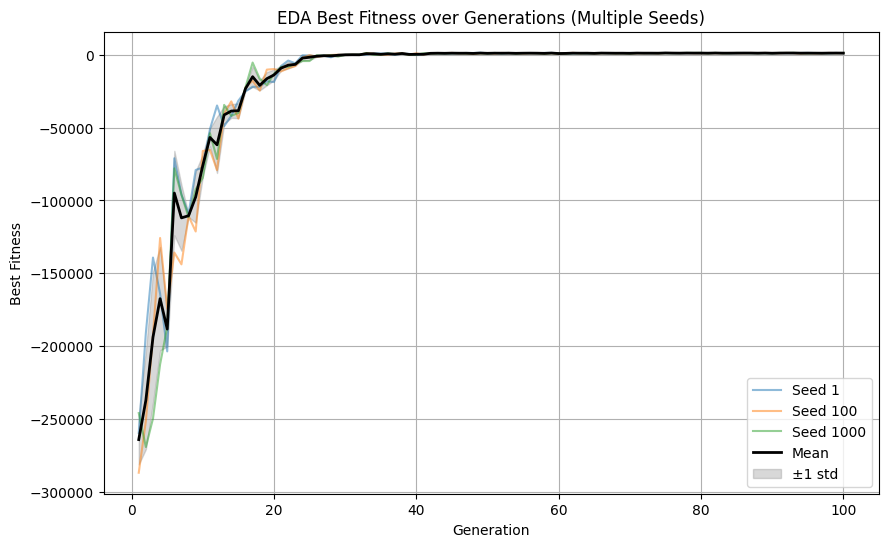

,generation,mean_best,std_best
0,1,-264089.461642,17006.063726
1,2,-237095.809045,33551.340387
2,3,-193795.065997,45087.888177
3,4,-167411.407035,35462.008962
4,5,-188259.769179,11976.994772
...,...,...,...
95,96,1024.333333,90.426152
96,97,990.333333,26.599916
97,98,1057.000000,87.799013
98,99,1082.000000,47.081490


In [236]:
items_269 = read_file("data/knapsack-data_2/10_269")
items_10000 = read_file("data/knapsack-data_2/23_10000")
items_995 = read_file("data/knapsack-data_2/100_995")

seed_res = run_with_seed(items_995)

plot_seed_results(seed_res)

